In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
NUM_ITER = 20
k = 5000 #use for taking expectation in computing loss

In [3]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    S_new_train = S_new[:int(0.8*k)]
    S_new_test = S_new[int(0.8*k):]
    return S_new, S_new_train, S_new_test
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new, S_new_train, S_new_test = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [7]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs
    
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = 2*m
    else:
        dset = prime_test_loss_samples
        leng = 2*(n-m)
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        out_is = out.cpu().detach().numpy().flatten()[0] * pmf * get_x_pmf() * leng * ind
        outs.append(out_is)
        res = np.average(outs)
    return res

def plot_loss(train_loss, test_loss, i, j, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.title('Loss after ' +  str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, i, j, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.title('Recall after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()
    
def plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma):
    plt.plot(train_cdf, 'b', label='Train CDF')
    plt.plot(test_cdf, 'y', label='Test CDF')
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

In [8]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [9]:
def sgd(lamb=1e28, #hyperparam
        gamma=1e-3): #step size
    
    optim = SGD(model.parameters(), lr=gamma)

    for j in range(NUM_ITER):
        
        train_losses = []
        train_recalls = []
        train_recall_outputs = [] 

        test_losses = []
        test_recalls = []
        test_recall_outputs = []

        new_outputs = []

        train_correct = 0
        test_correct = 0
        
        for i, ele in enumerate(tqdm.tqdm(train_ds)):
            if i == 0:
                continue
            model.train()
            optim.zero_grad() #reset gradients after update
            x, y = convert(ele[0], ele[1]) #sample x,y from S_train
            out = update(x, y) #get S_train output/score
            log_out = torch.log(out) #take log
            # Calculate train recall
            train_score = out.cpu().detach().numpy().flatten()[0] #get score in float
            if train_score > 0.6:
                train_correct += 1 #contribute to train recall
            train_recall_outputs.append(train_score) #store the train scores

            optim.zero_grad() #reset gradients for the second branch
            y_pmf = get_y_pmf(ele[2][1])
            x_prime, y_prime = convert(ele[2][0], ele[2][1]) #sample x', y' from S_prime_train
            out_prime = update(x_prime, y_prime) #get score'
            out_prime = out_prime*y_pmf*get_x_pmf()*2*m #adjust for IS
            const = ele[3] #indicator
            (lamb*const*out_prime - log_out).backward(retain_graph=True) #backprop
            optim.step() #gradient update

            model.eval()
            x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
            test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0] #get test score in float
            test_recall_outputs.append(test_score) #store the test scores
            if test_score > 0.6:
                test_correct += 1 #contribute to test recall

            #generate 10 unseen examples from S_new as compared 1 example from validate/train for cdfs
            for x, y in S_new[10*i:10*(i+1)]:
                x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
                new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
                new_outputs.append(new_score) #store the new unknown scores

            if i % 1000 == 0:
                train_loss = lamb*get_out_prime("train") - get_log_out('train') #training loss
                test_loss = (m/(n-m))*lamb*get_out_prime("test") - get_log_out('test') #test loss
                train_losses.append(train_loss)
                test_losses.append(test_loss)

                train_recall = 100*train_correct/i #training recall
                train_recalls.append(train_recall) 
                test_recall = 100*test_correct/i #test recall
                test_recalls.append(test_recall)
                if i > 1000:
                    train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                    test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
                else:
                    train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                    test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores
                train_cdf = np.cumsum(train_score)/np.sum(train_score) #train cdf
                test_cdf = np.cumsum(test_score)/np.sum(test_score) #test cdf


            if i % 10000 == 0:
                plot_recall(train_recalls, test_recalls, i, j, lamb, gamma)
                plot_loss(train_losses, test_losses, i, j, lamb, gamma)
                plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma)
                print("New score: ", np.average(new_outputs[-20:]))
                print("Train score: ", np.average(train_score[-20:]))
                print("Test score: ", np.average(test_score[-20:]))

## Hyperparameter tuning

In [10]:
gammas = [1e-3]
lambdas = [5e28]

  2%|▏         | 9993/473047 [03:50<1:41:10, 76.29it/s]  

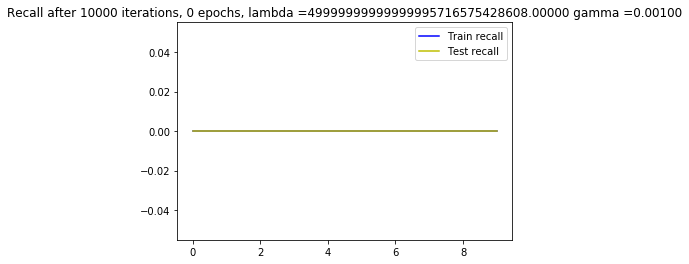

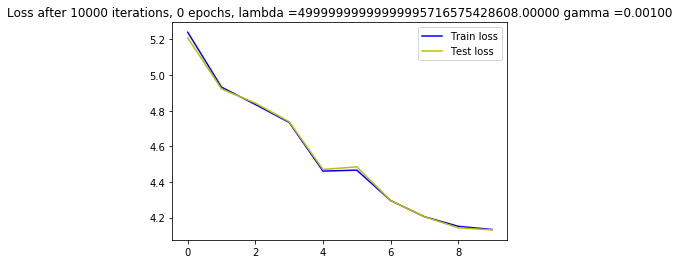

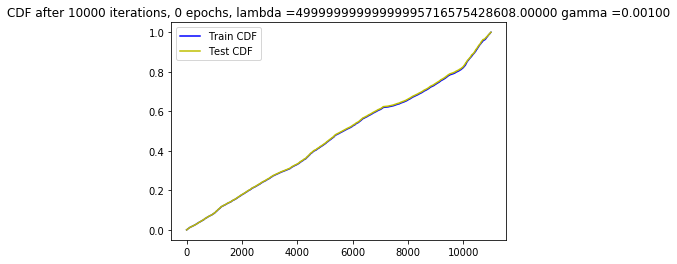

  2%|▏         | 10009/473047 [04:02<40:54:10,  3.14it/s]

New score:  0.02640799
Train score:  0.054895103
Test score:  0.048283283


  4%|▍         | 19993/473047 [07:54<1:38:25, 76.72it/s] 

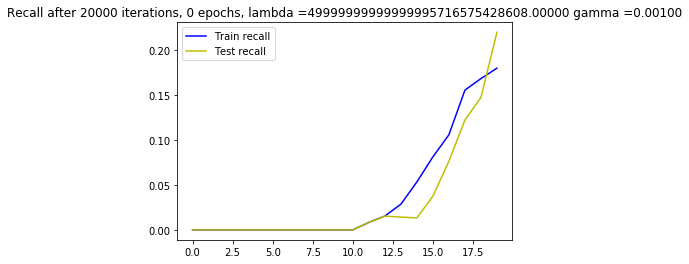

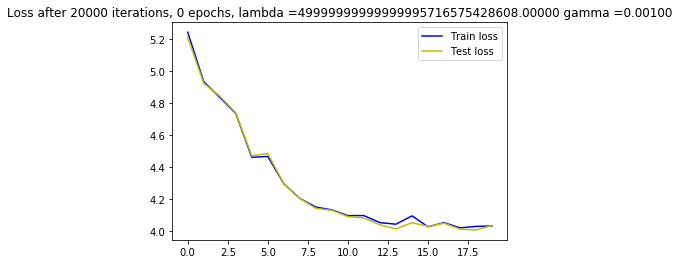

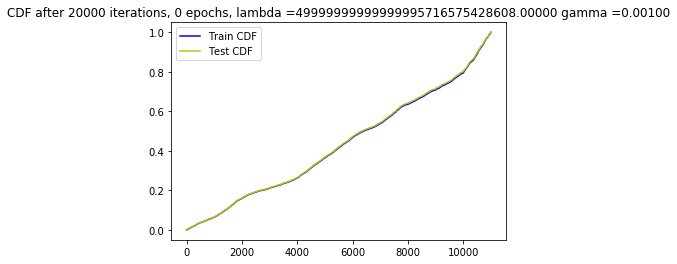

  4%|▍         | 20009/473047 [08:05<39:43:41,  3.17it/s]

New score:  0.033836007
Train score:  0.111284986
Test score:  0.09094794


  6%|▋         | 29993/473047 [12:03<1:36:12, 76.75it/s]  

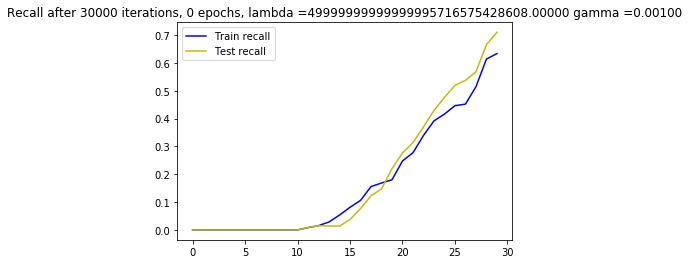

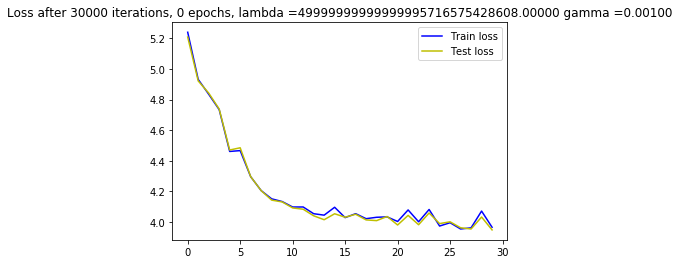

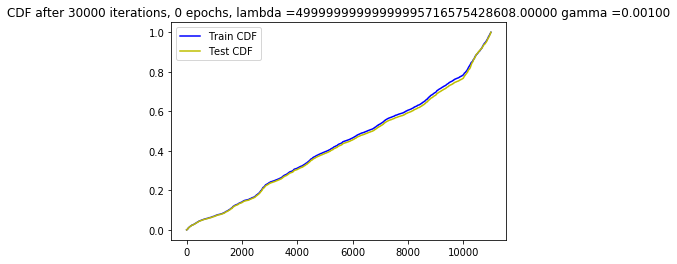

  6%|▋         | 30009/473047 [12:16<42:35:24,  2.89it/s]

New score:  0.049850397
Train score:  0.15675958
Test score:  0.19070214


  8%|▊         | 39998/473047 [16:12<1:34:13, 76.60it/s]  

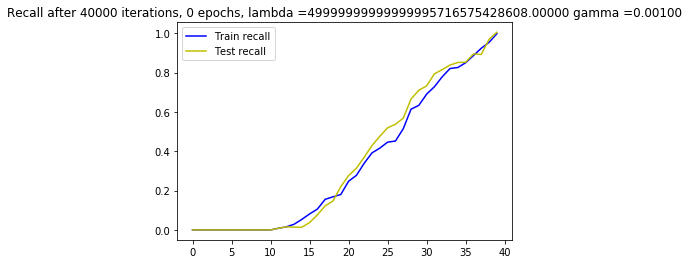

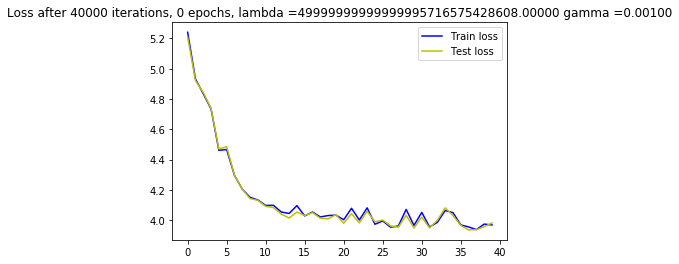

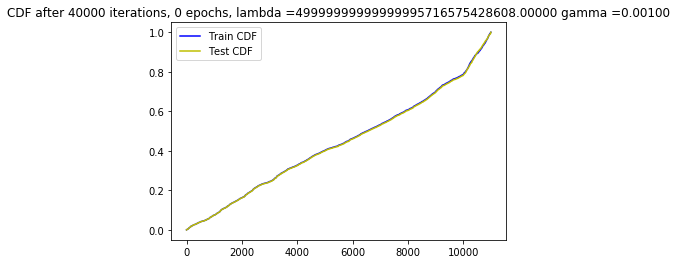

  8%|▊         | 40014/473047 [16:24<37:51:09,  3.18it/s]

New score:  0.045581773
Train score:  0.114057764
Test score:  0.24891853


 11%|█         | 49997/473047 [20:14<1:32:28, 76.25it/s]  

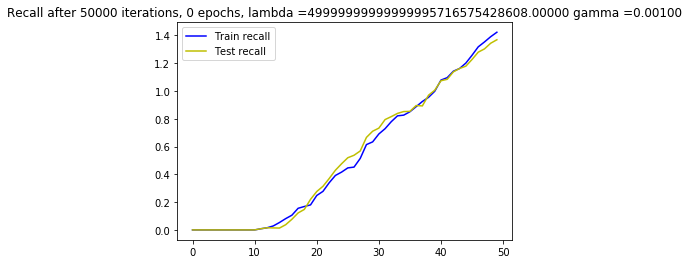

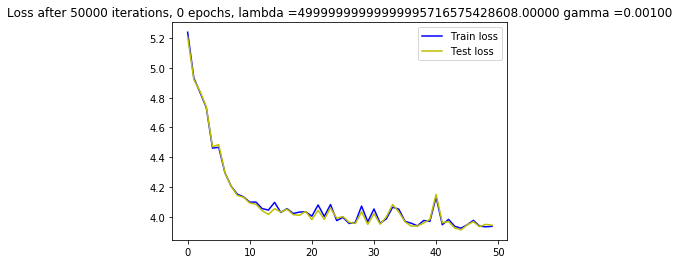

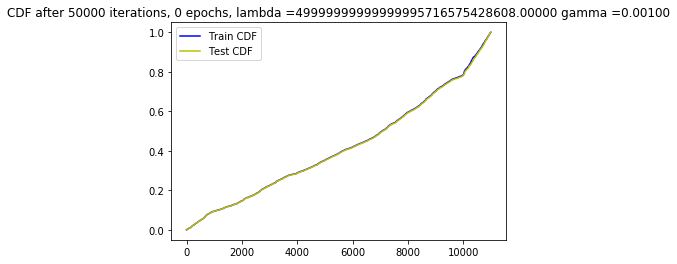

 11%|█         | 50013/473047 [20:26<37:07:36,  3.17it/s]

New score:  0.03577966
Train score:  0.0776286
Test score:  0.07200626


 13%|█▎        | 59993/473047 [24:17<1:30:00, 76.49it/s]  

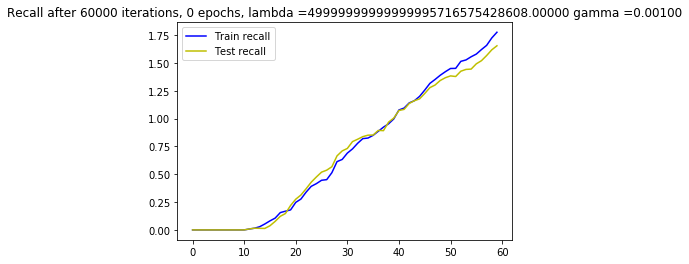

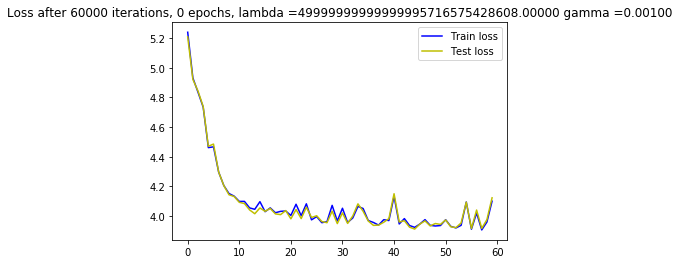

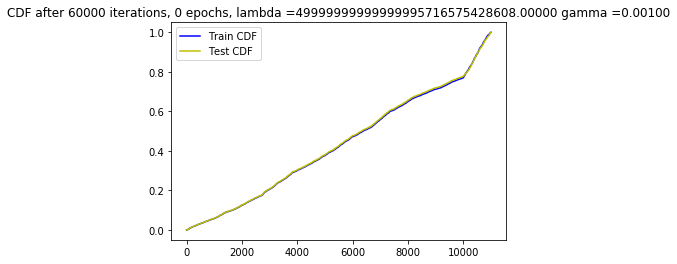

 13%|█▎        | 60009/473047 [24:29<36:09:25,  3.17it/s]

New score:  0.05247135
Train score:  0.0647299
Test score:  0.14800684


 15%|█▍        | 69993/473047 [28:22<1:29:02, 75.44it/s] 

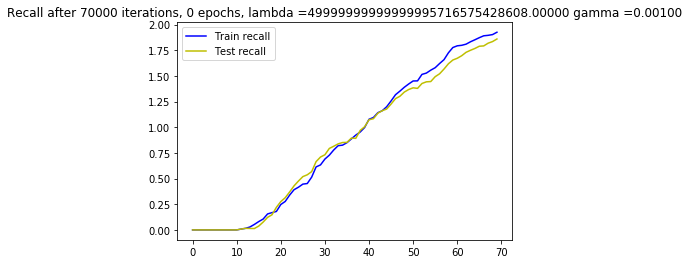

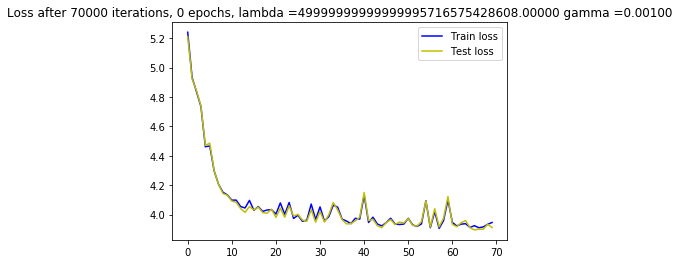

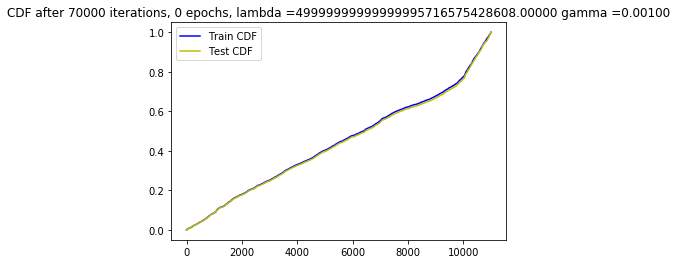

 15%|█▍        | 70009/473047 [28:34<36:20:46,  3.08it/s]

New score:  0.04344713
Train score:  0.17604306
Test score:  0.108122565


 17%|█▋        | 79996/473047 [32:30<1:25:16, 76.83it/s] 

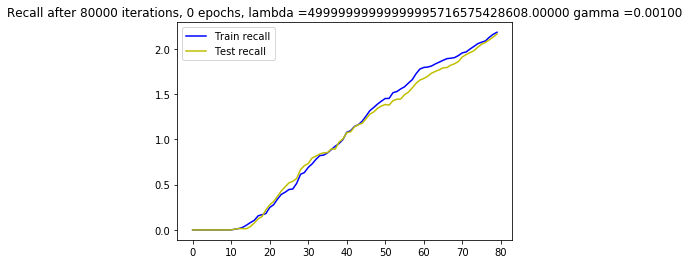

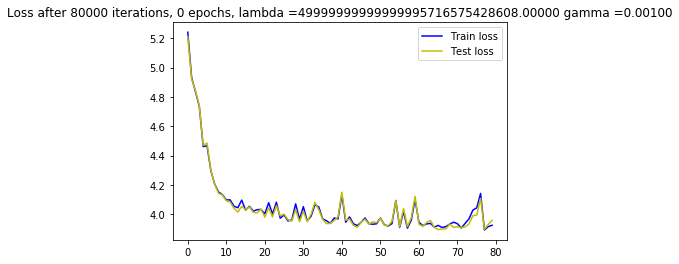

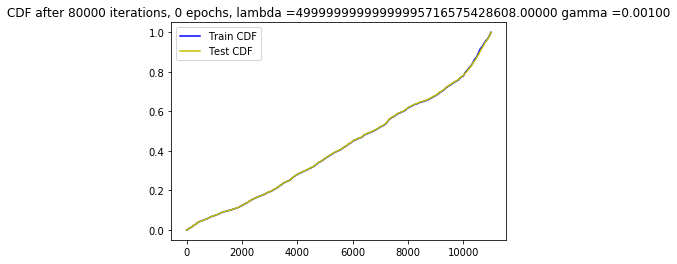

 17%|█▋        | 80012/473047 [32:42<35:20:53,  3.09it/s]

New score:  0.052808423
Train score:  0.17838144
Test score:  0.259925


 19%|█▉        | 89999/473047 [36:50<1:33:39, 68.16it/s] 

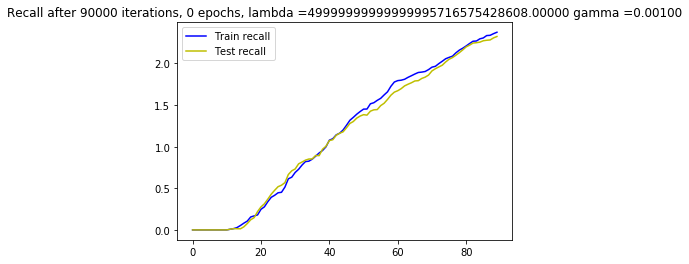

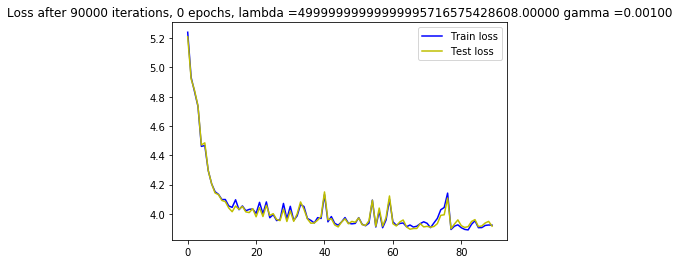

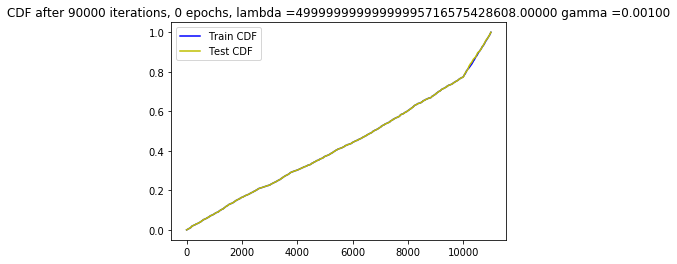

 19%|█▉        | 90008/473047 [36:51<152:54:40,  1.44s/it]

New score:  0.08394978
Train score:  0.17322572
Test score:  0.17057946


 21%|██        | 99993/473047 [40:46<1:26:41, 71.73it/s]  

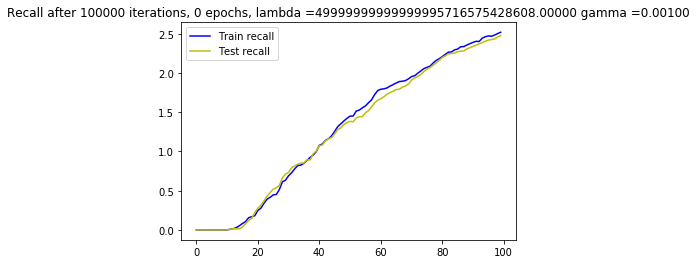

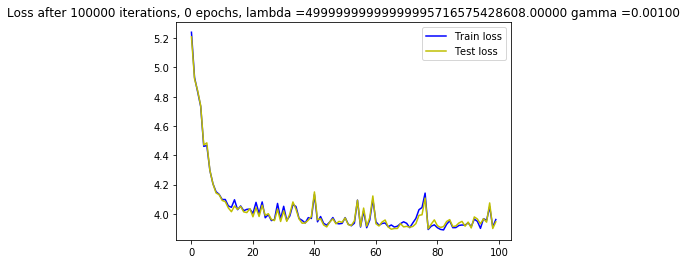

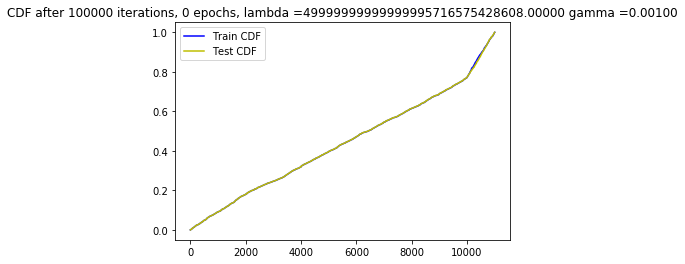

 21%|██        | 100009/473047 [40:58<33:21:33,  3.11it/s]

New score:  0.07178757
Train score:  0.17798755
Test score:  0.14711939


 23%|██▎       | 109996/473047 [44:55<1:20:51, 74.84it/s] 

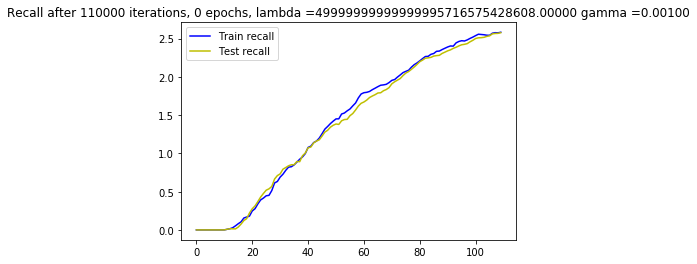

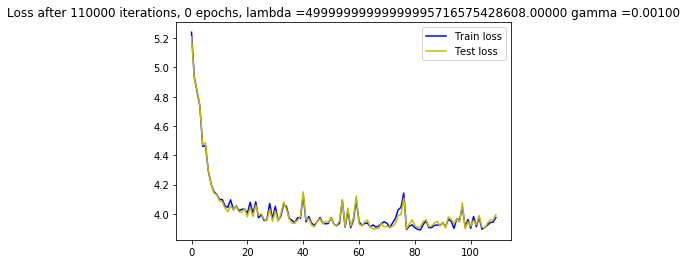

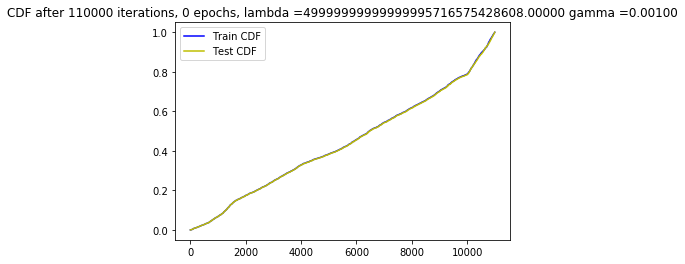

 23%|██▎       | 110012/473047 [45:07<32:37:32,  3.09it/s]

New score:  0.023356307
Train score:  0.15094468
Test score:  0.19361775


 25%|██▌       | 119993/473047 [49:02<1:18:45, 74.72it/s] 

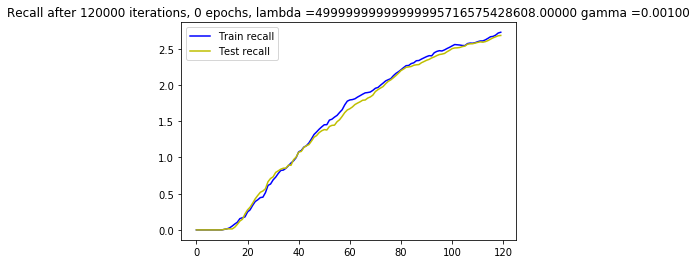

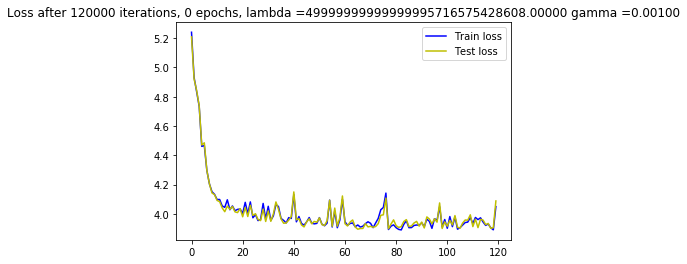

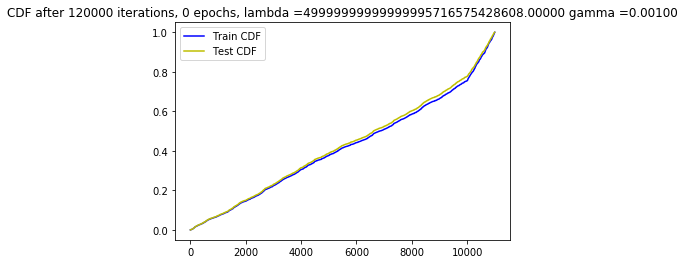

 25%|██▌       | 120009/473047 [49:14<32:00:36,  3.06it/s]

New score:  0.036901824
Train score:  0.16606753
Test score:  0.050479013


 27%|██▋       | 129993/473047 [53:20<1:15:22, 75.86it/s] 

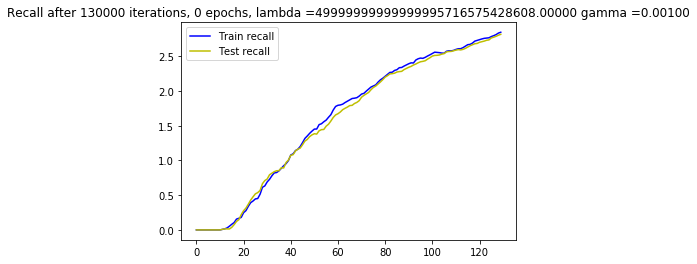

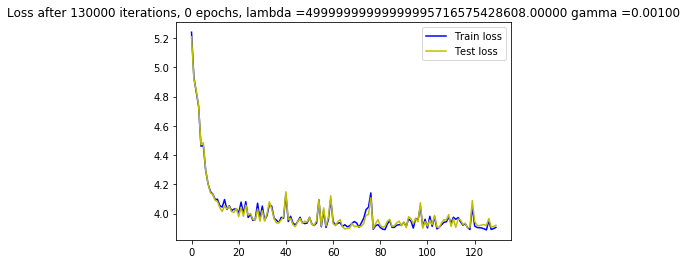

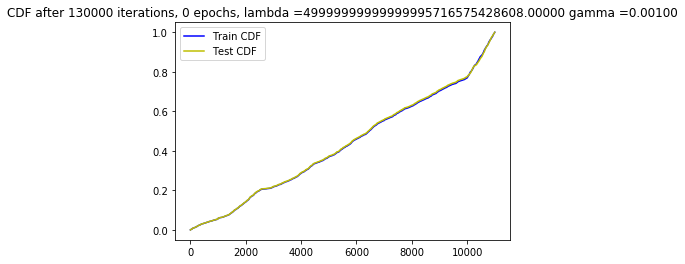

 27%|██▋       | 130009/473047 [53:20<30:34:11,  3.12it/s]

New score:  0.041208252
Train score:  0.13638982
Test score:  0.12968291


 30%|██▉       | 139993/473047 [57:15<1:13:22, 75.65it/s] 

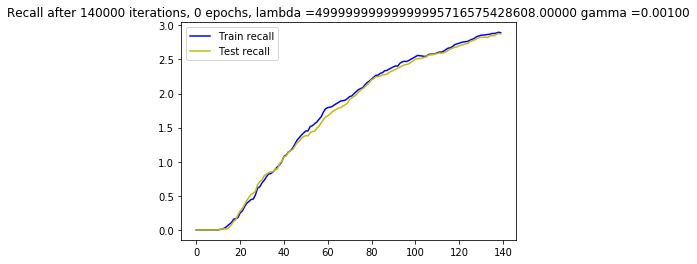

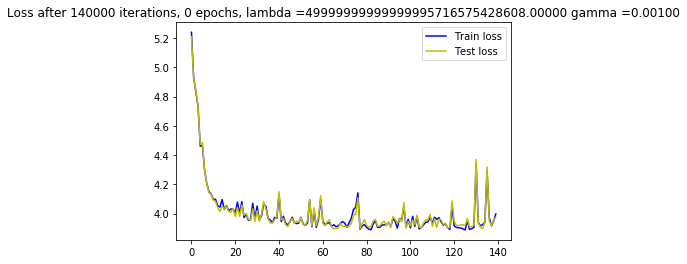

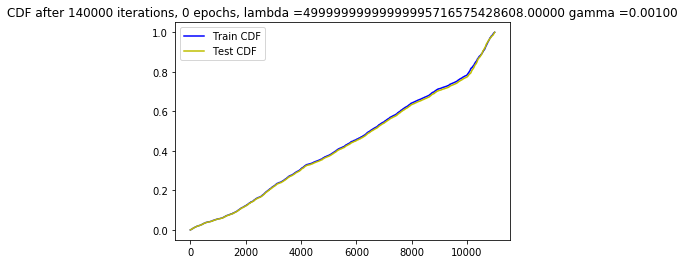

 30%|██▉       | 140009/473047 [57:27<29:54:22,  3.09it/s]

New score:  0.030801866
Train score:  0.060214452
Test score:  0.113973655


 32%|███▏      | 149993/473047 [1:01:23<1:12:25, 74.34it/s] 

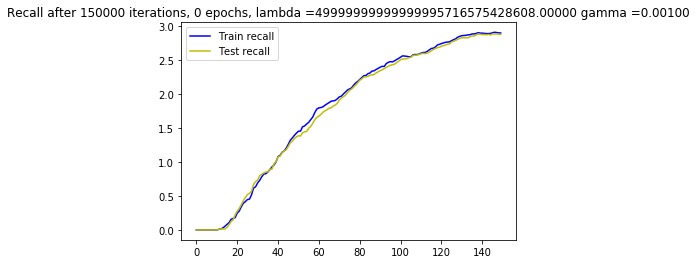

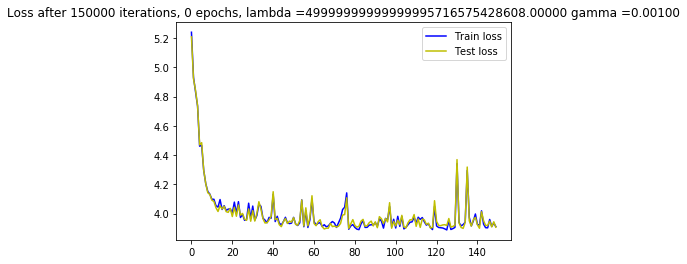

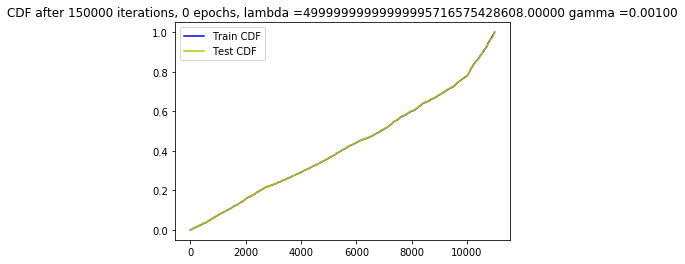

 32%|███▏      | 150009/473047 [1:01:35<29:05:54,  3.08it/s]

New score:  0.04366265
Train score:  0.09407128
Test score:  0.19150896


 34%|███▍      | 159997/473047 [1:05:31<1:09:15, 75.33it/s] 

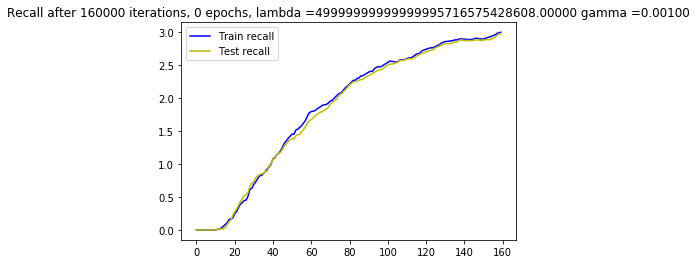

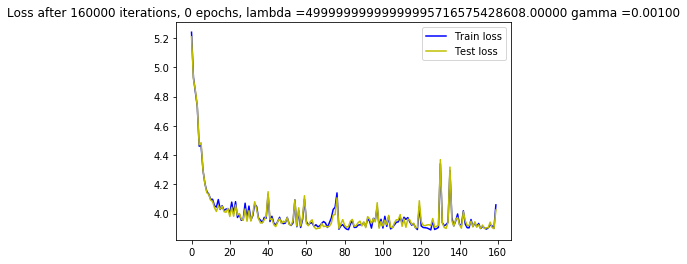

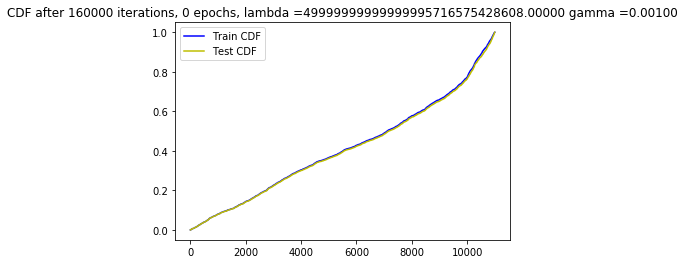

 34%|███▍      | 160013/473047 [1:05:43<28:08:13,  3.09it/s]

New score:  0.07312013
Train score:  0.081157975
Test score:  0.2157865


 36%|███▌      | 169993/473047 [1:09:50<1:07:26, 74.89it/s] 

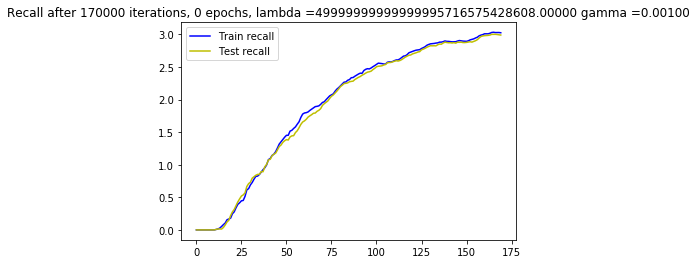

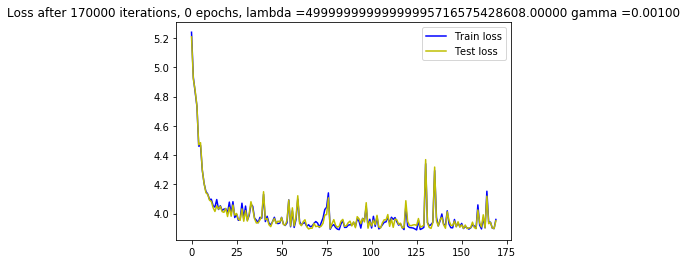

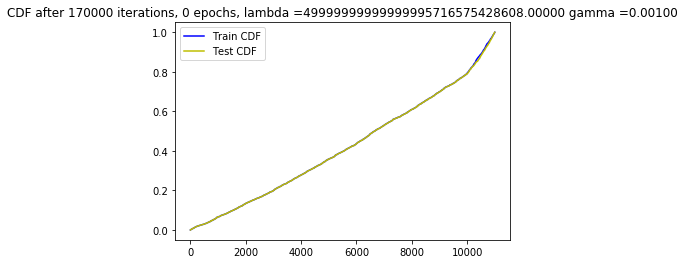

 36%|███▌      | 170009/473047 [1:09:50<27:03:06,  3.11it/s]

New score:  0.0646631
Train score:  0.16256617
Test score:  0.13514715


 38%|███▊      | 179998/473047 [1:13:36<57:51, 84.42it/s]   

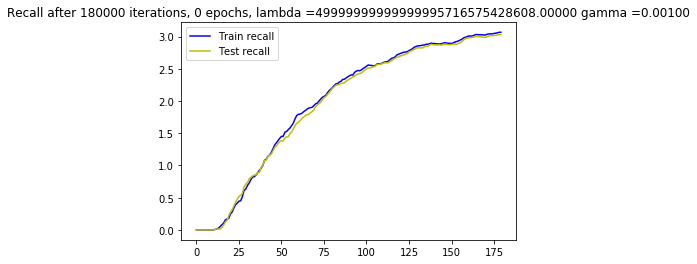

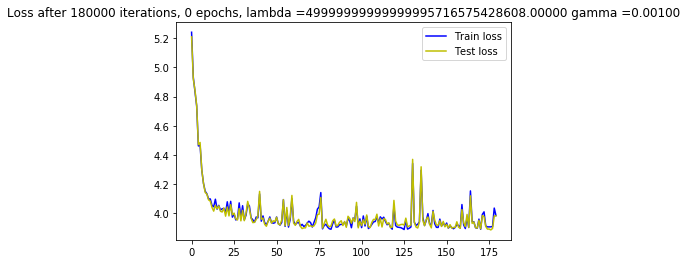

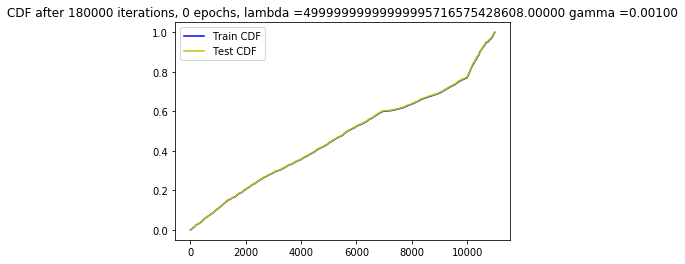

 38%|███▊      | 180016/473047 [1:13:48<23:31:54,  3.46it/s]

New score:  0.040938124
Train score:  0.12666498
Test score:  0.10848733


 40%|████      | 189996/473047 [1:17:41<54:43, 86.21it/s]   

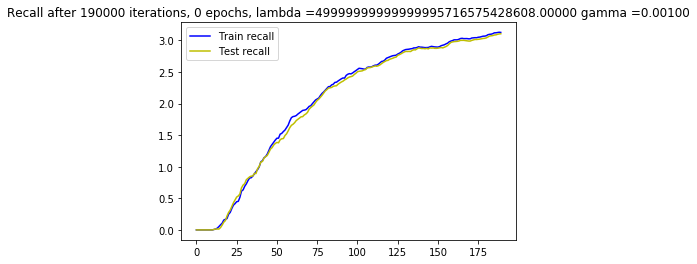

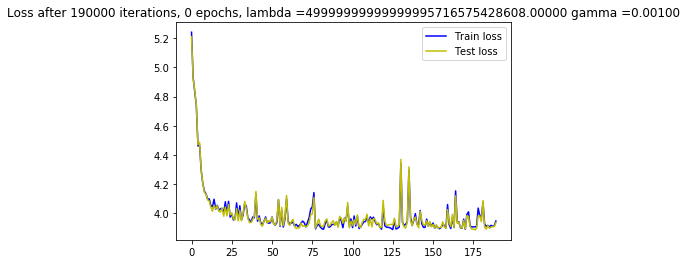

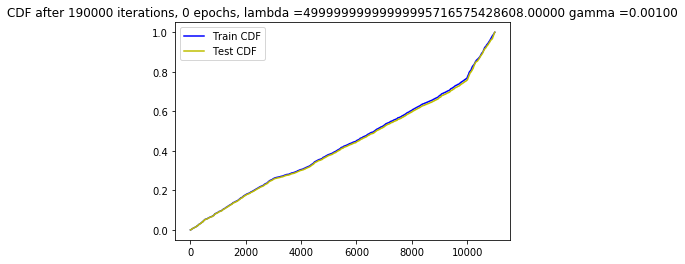

 40%|████      | 190014/473047 [1:17:52<22:11:51,  3.54it/s]

New score:  0.04067087
Train score:  0.119846925
Test score:  0.14607279


 42%|████▏     | 200000/473047 [1:21:32<51:29, 88.39it/s]    

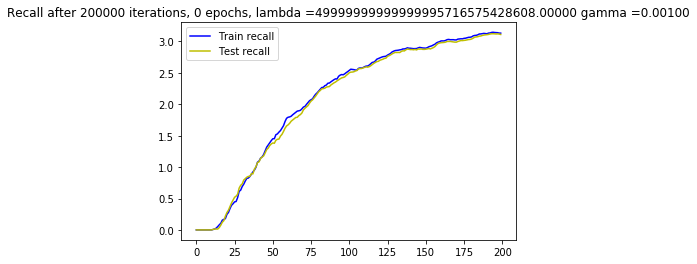

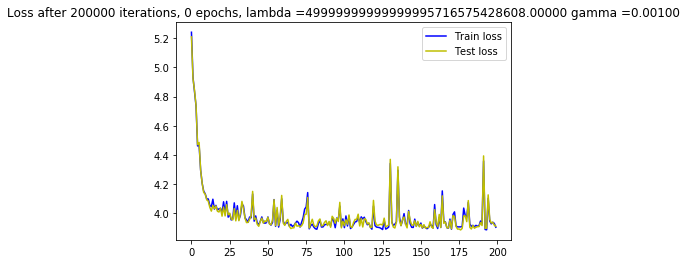

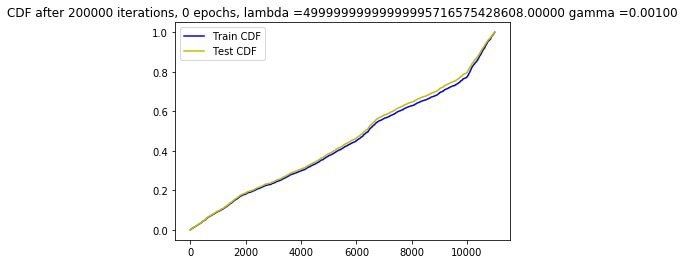

 42%|████▏     | 200009/473047 [1:21:44<30:48:55,  2.46it/s]

New score:  0.043786027
Train score:  0.1529561
Test score:  0.10606241


 44%|████▍     | 209999/473047 [1:30:30<7:25:28,  9.84it/s]   

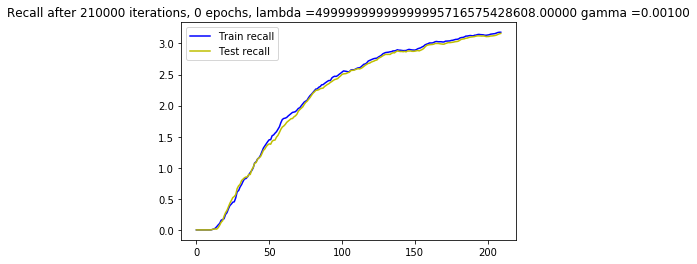

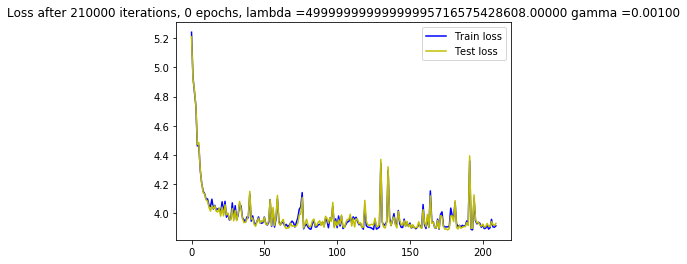

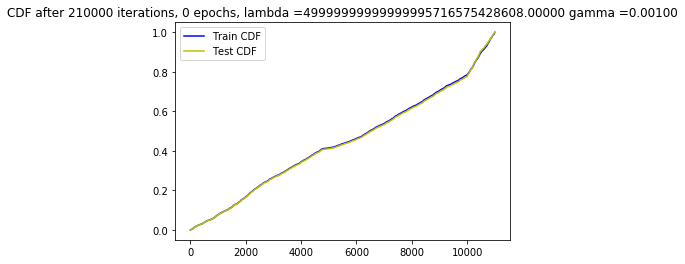

 44%|████▍     | 210002/473047 [1:31:28<547:05:47,  7.49s/it]

New score:  0.06424652
Train score:  0.17547324
Test score:  0.14312527


 47%|████▋     | 220000/473047 [1:54:40<5:14:00, 13.43it/s]   

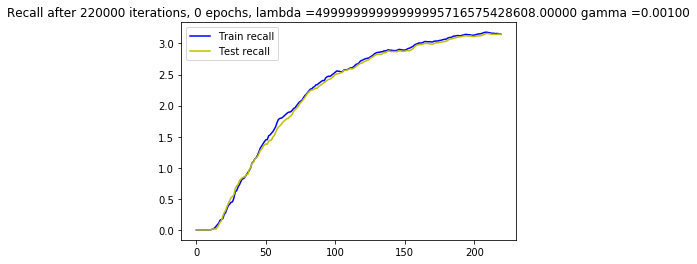

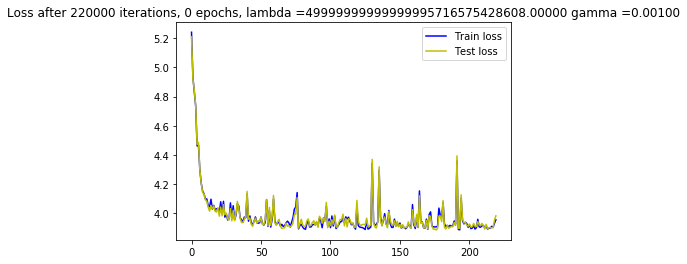

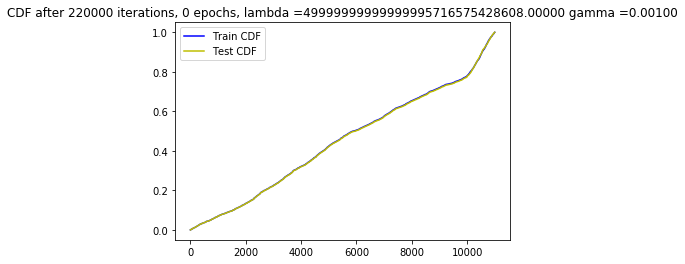

 47%|████▋     | 220002/473047 [1:55:34<964:34:26, 13.72s/it] 

New score:  0.042174935
Train score:  0.08780557
Test score:  0.06777356


 49%|████▊     | 230000/473047 [2:18:20<3:09:10, 21.41it/s]   

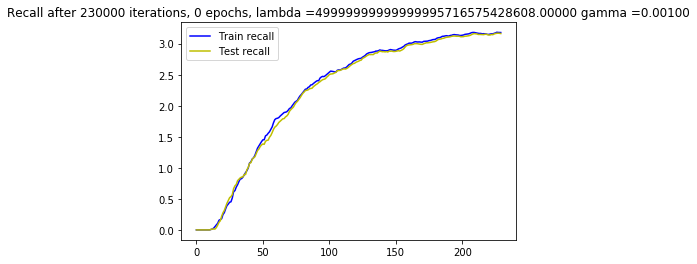

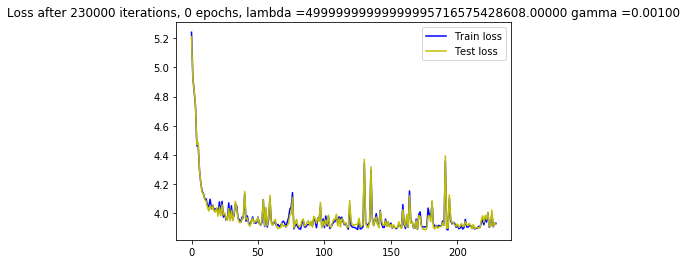

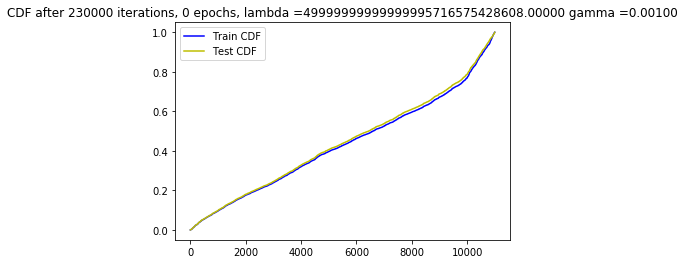

 49%|████▊     | 230002/473047 [2:19:09<897:04:56, 13.29s/it] 

New score:  0.037176587
Train score:  0.09566103
Test score:  0.1837488


 51%|█████     | 240000/473047 [2:41:10<3:27:37, 18.71it/s]   

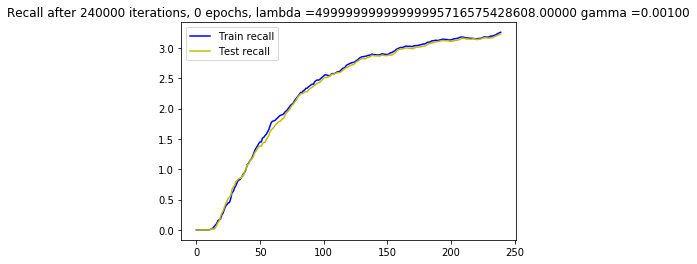

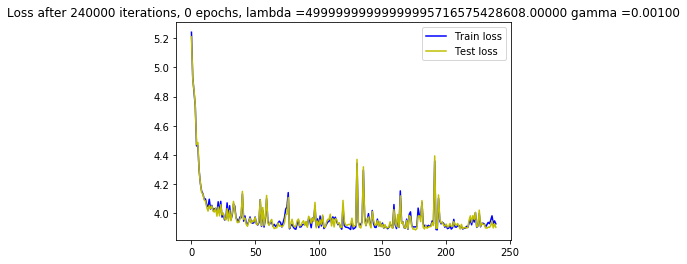

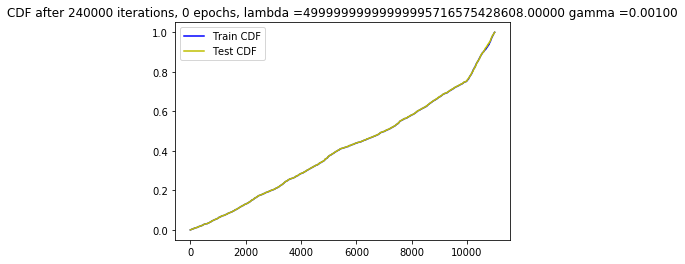

 51%|█████     | 240002/473047 [2:41:58<877:11:23, 13.55s/it] 

New score:  0.0876652
Train score:  0.070489496
Test score:  0.12046877


 53%|█████▎    | 249995/473047 [3:04:10<2:06:34, 29.37it/s]   

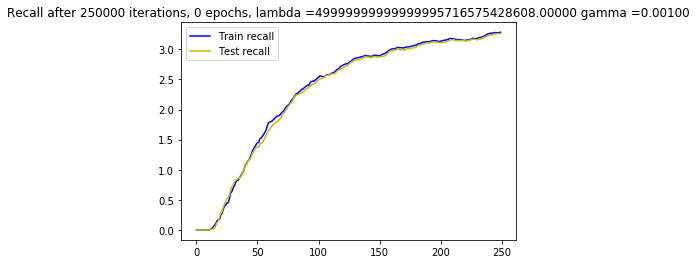

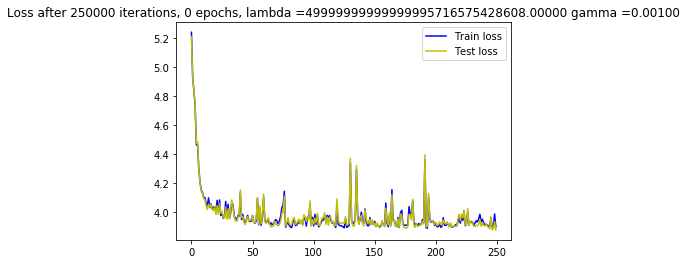

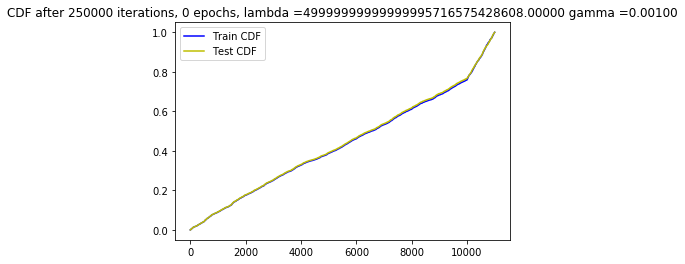

 53%|█████▎    | 250002/473047 [3:04:56<141:03:14,  2.28s/it]

New score:  0.021225596
Train score:  0.09439996
Test score:  0.09506993


 55%|█████▍    | 259999/473047 [3:27:00<2:47:21, 21.22it/s]   

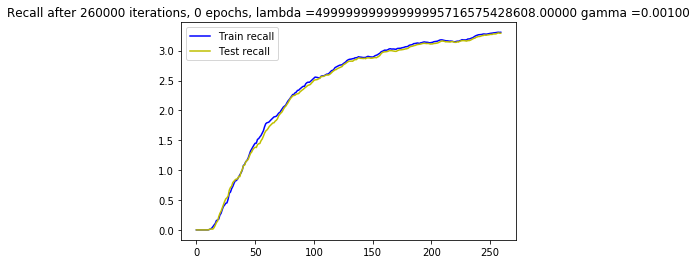

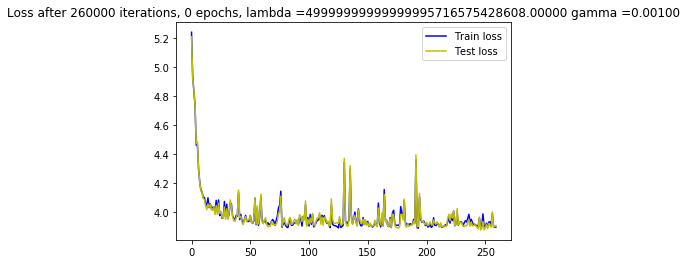

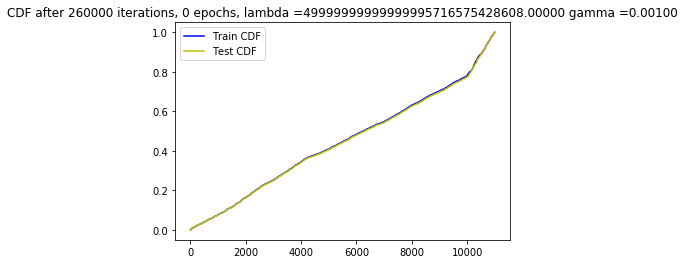

 55%|█████▍    | 260002/473047 [3:27:47<404:09:57,  6.83s/it]

New score:  0.030282844
Train score:  0.07471707
Test score:  0.118753776


 57%|█████▋    | 270000/473047 [3:49:40<5:26:02, 10.38it/s]   

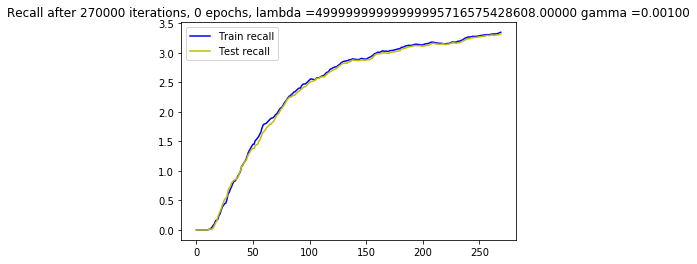

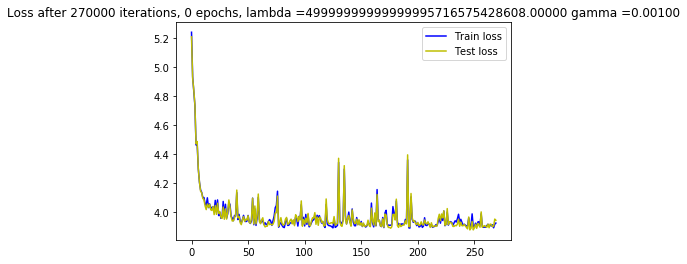

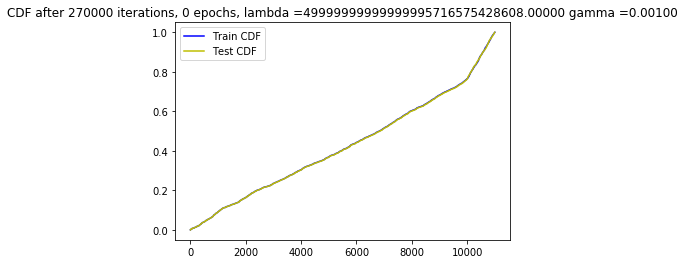

 57%|█████▋    | 270002/473047 [3:50:24<750:02:51, 13.30s/it] 

New score:  0.10457812
Train score:  0.13311371
Test score:  0.19010645


 59%|█████▉    | 279997/473047 [4:12:30<2:30:50, 21.33it/s]   

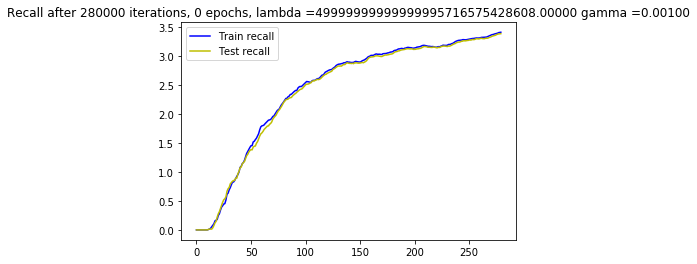

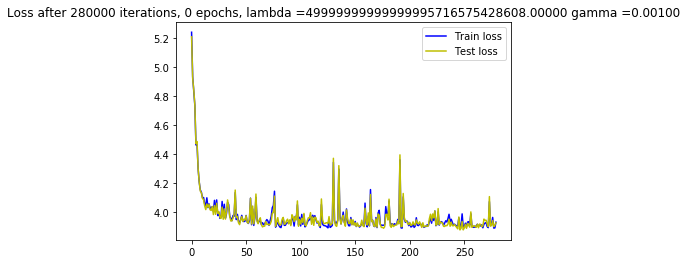

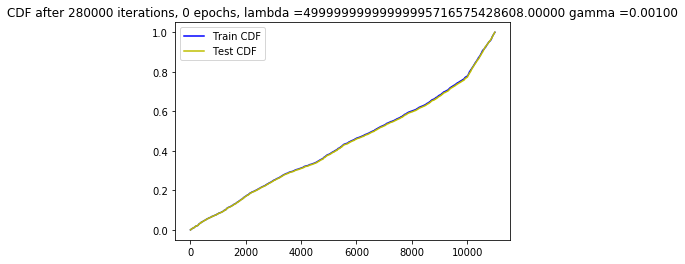

 59%|█████▉    | 280002/473047 [4:13:18<185:49:06,  3.47s/it]

New score:  0.026621038
Train score:  0.16868743
Test score:  0.1528615


 61%|██████▏   | 289999/473047 [4:35:40<5:27:26,  9.32it/s]   

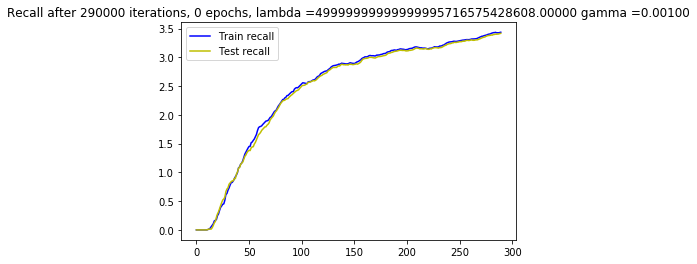

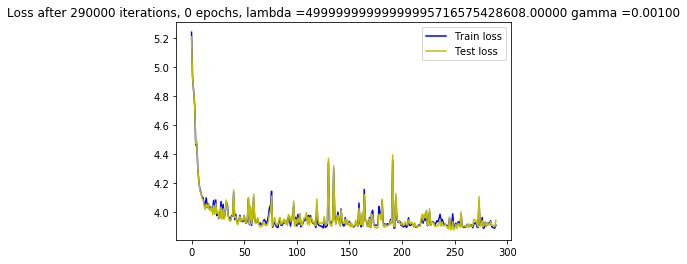

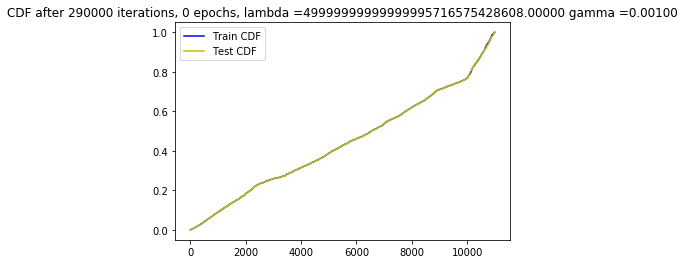

 61%|██████▏   | 290002/473047 [4:36:25<346:27:14,  6.81s/it]

New score:  0.067744724
Train score:  0.07890652
Test score:  0.1831167


 63%|██████▎   | 299999/473047 [4:58:40<1:41:55, 28.30it/s]  

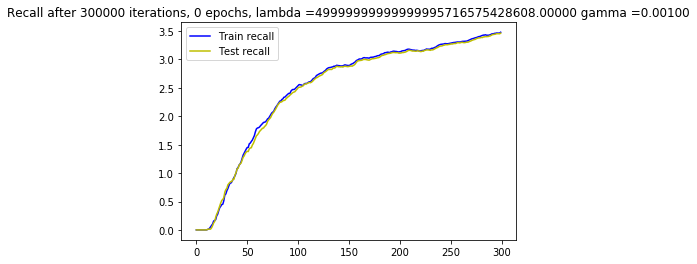

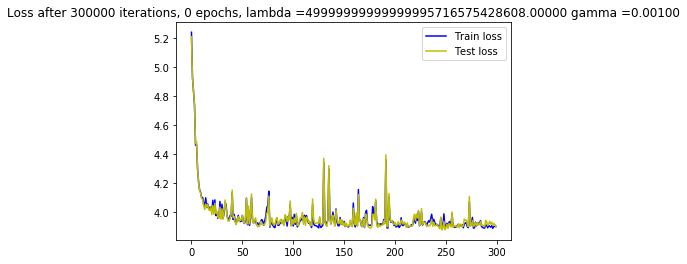

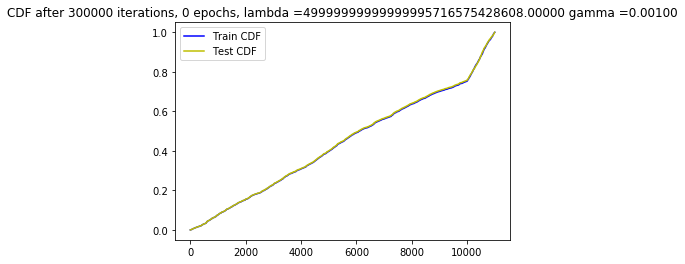

 63%|██████▎   | 300002/473047 [4:59:33<333:56:06,  6.95s/it]

New score:  0.048350397
Train score:  0.12687348
Test score:  0.22967894


 66%|██████▌   | 309999/473047 [5:21:40<4:35:18,  9.87it/s]  

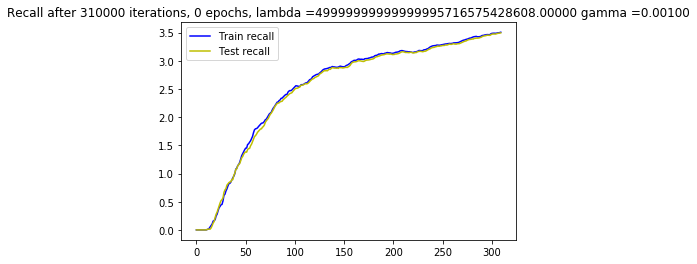

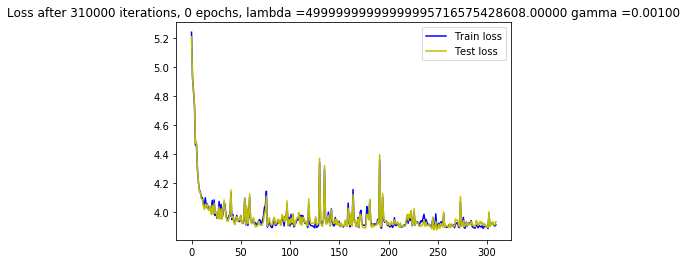

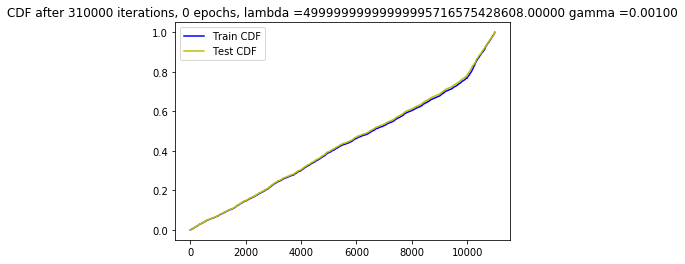

 66%|██████▌   | 310002/473047 [5:22:30<321:26:15,  7.10s/it]

New score:  0.041933917
Train score:  0.24077106
Test score:  0.2180105


 68%|██████▊   | 319999/473047 [5:44:40<3:12:15, 13.27it/s]  

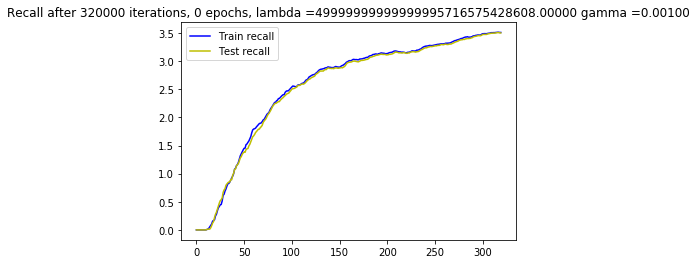

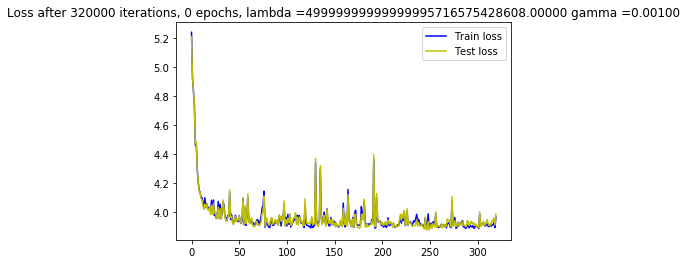

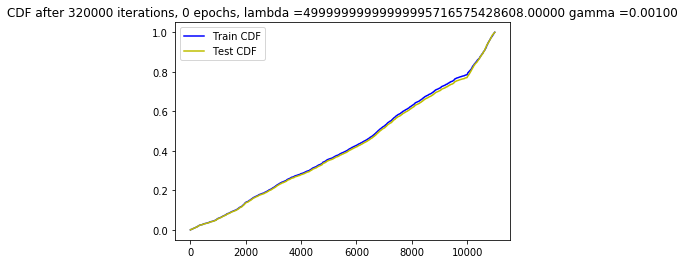

 68%|██████▊   | 320002/473047 [5:45:32<279:52:13,  6.58s/it]

New score:  0.028826486
Train score:  0.109249495
Test score:  0.10022112


 70%|██████▉   | 329999/473047 [6:07:51<4:20:32,  9.15it/s]  

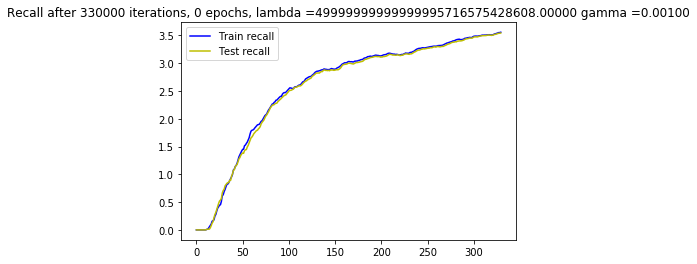

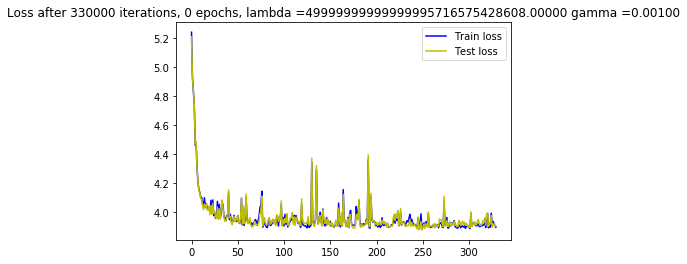

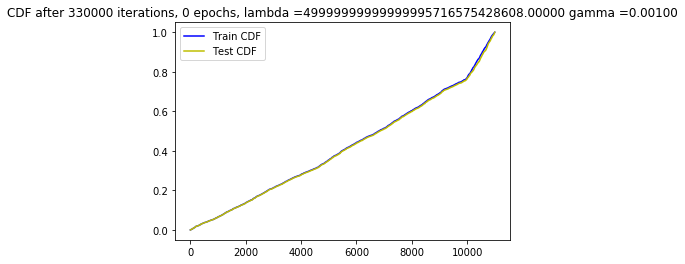

 70%|██████▉   | 330002/473047 [6:08:41<274:44:36,  6.91s/it]

New score:  0.064911015
Train score:  0.092572466
Test score:  0.2557404


 72%|███████▏  | 339998/473047 [6:30:51<1:16:14, 29.08it/s]  

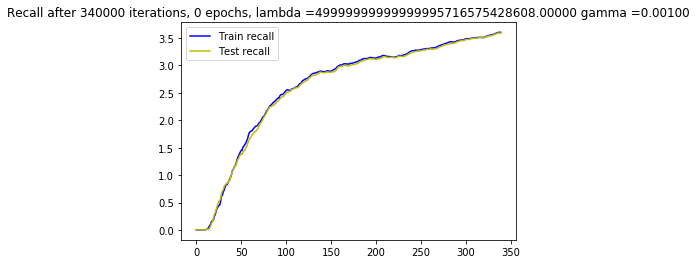

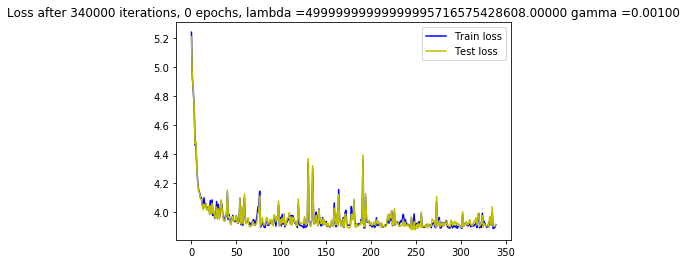

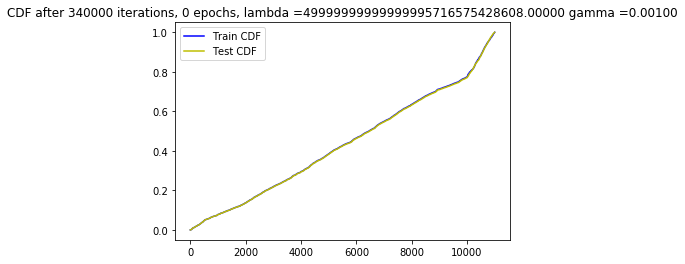

 72%|███████▏  | 340002/473047 [6:31:41<167:15:56,  4.53s/it]

New score:  0.027503539
Train score:  0.13357654
Test score:  0.08296712


 74%|███████▍  | 350000/473047 [6:53:38<3:58:41,  8.59it/s]  

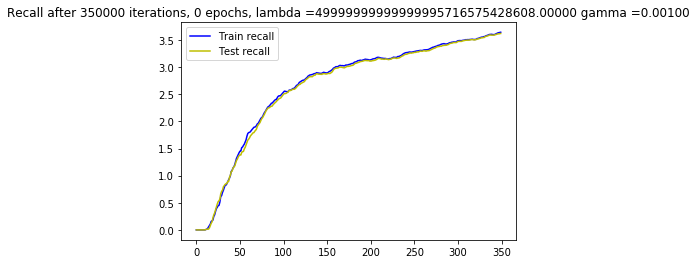

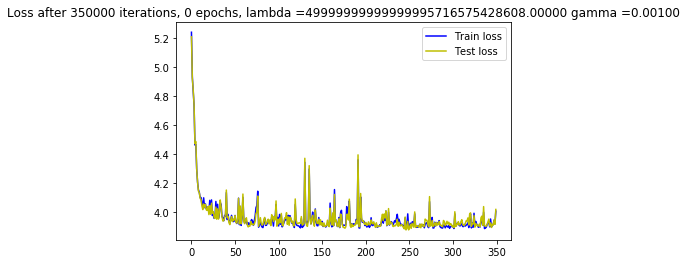

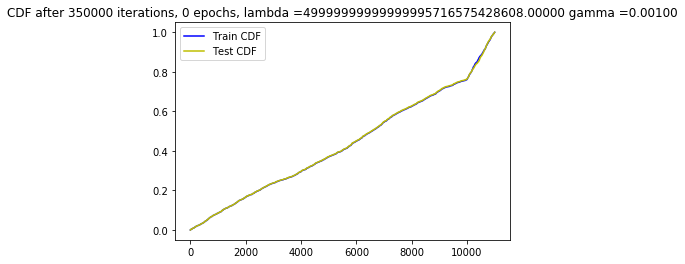

 74%|███████▍  | 350002/473047 [6:54:43<468:50:46, 13.72s/it]

New score:  0.048902463
Train score:  0.11587139
Test score:  0.08945806


 76%|███████▌  | 359998/473047 [7:17:31<2:52:08, 10.94it/s]  

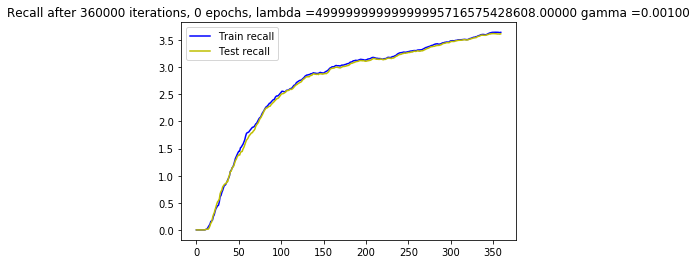

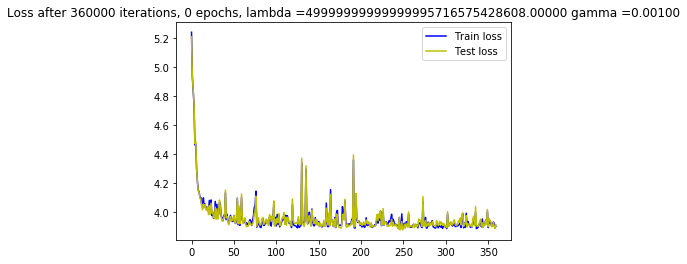

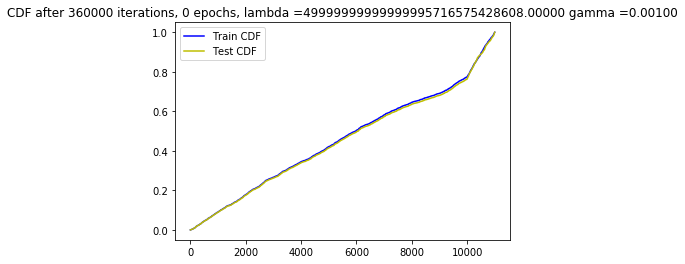

 76%|███████▌  | 360002/473047 [7:18:22<154:00:27,  4.90s/it]

New score:  0.041038156
Train score:  0.16256885
Test score:  0.21380751


 78%|███████▊  | 369997/473047 [7:40:41<56:22, 30.46it/s]    

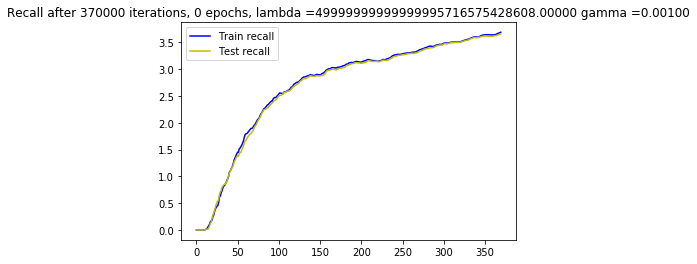

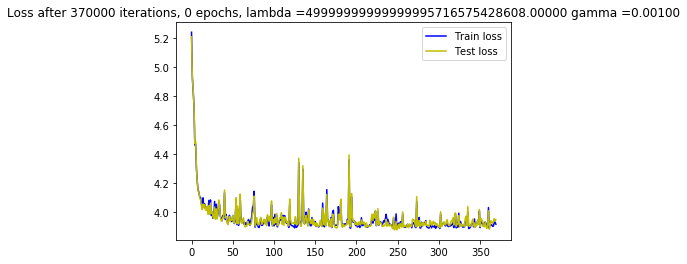

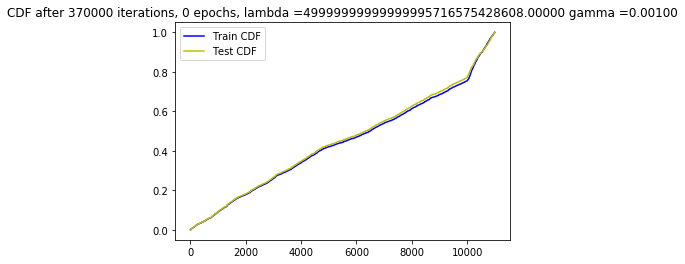

 78%|███████▊  | 370002/473047 [7:41:26<96:09:35,  3.36s/it] 

New score:  0.03685186
Train score:  0.121065736
Test score:  0.15925542


 80%|████████  | 379999/473047 [8:03:01<1:14:43, 20.75it/s]  

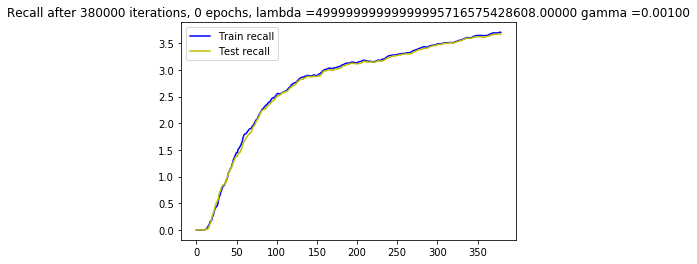

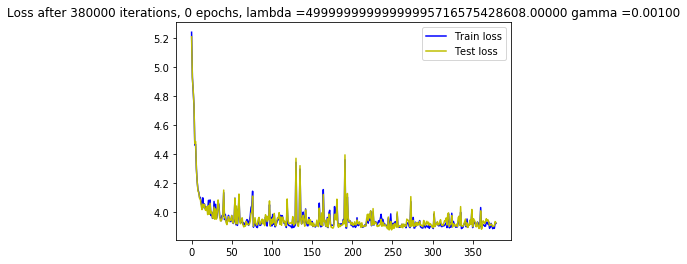

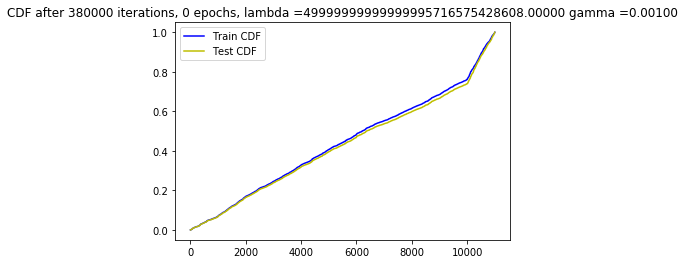

 80%|████████  | 380002/473047 [8:03:45<170:55:09,  6.61s/it]

New score:  0.020858236
Train score:  0.14415781
Test score:  0.14652652


 82%|████████▏ | 390000/473047 [8:25:11<54:39, 25.33it/s]    

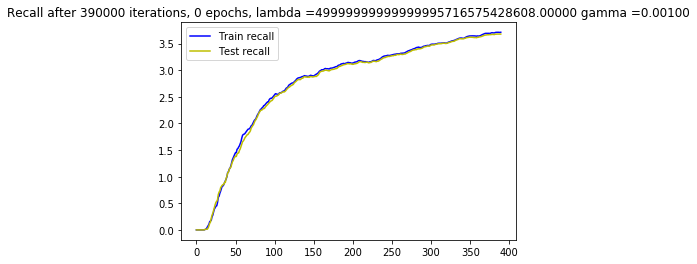

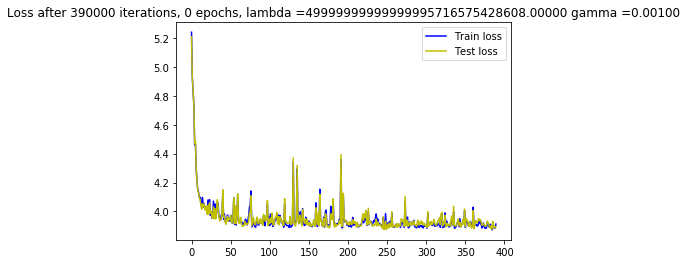

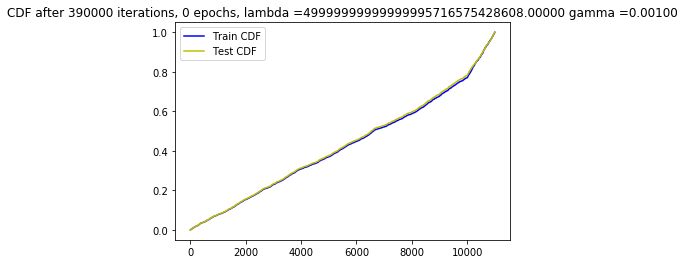

 82%|████████▏ | 390002/473047 [8:25:56<300:49:25, 13.04s/it]

New score:  0.026961979
Train score:  0.19777703
Test score:  0.14574067


 85%|████████▍ | 399997/473047 [8:47:01<1:08:33, 17.76it/s]  

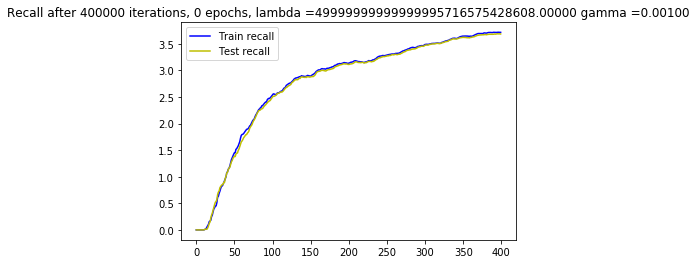

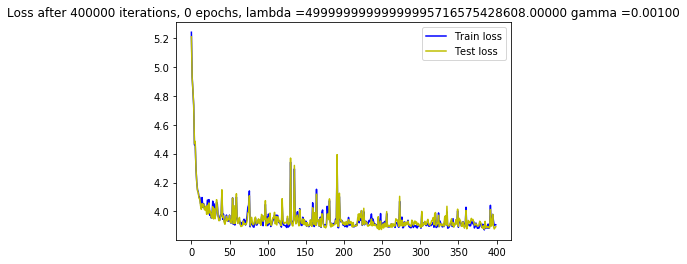

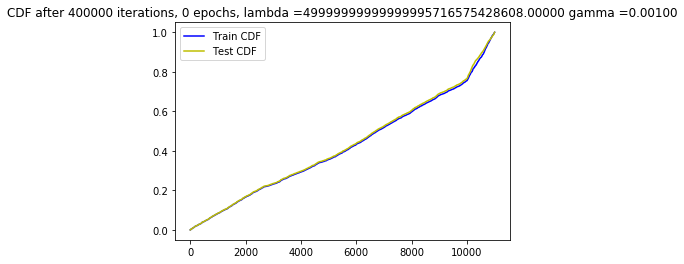

 85%|████████▍ | 400005/473047 [8:47:49<66:35:03,  3.28s/it]

New score:  0.053314067
Train score:  0.14149602
Test score:  0.17402609


 85%|████████▍ | 400781/473047 [8:48:44<2:12:19,  9.10it/s] 

In [ ]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = SimpleConvNet()
        model.apply(weights_init)
        model.cuda()
        sgd(gamma=gammas[g], lamb=lambdas[l])